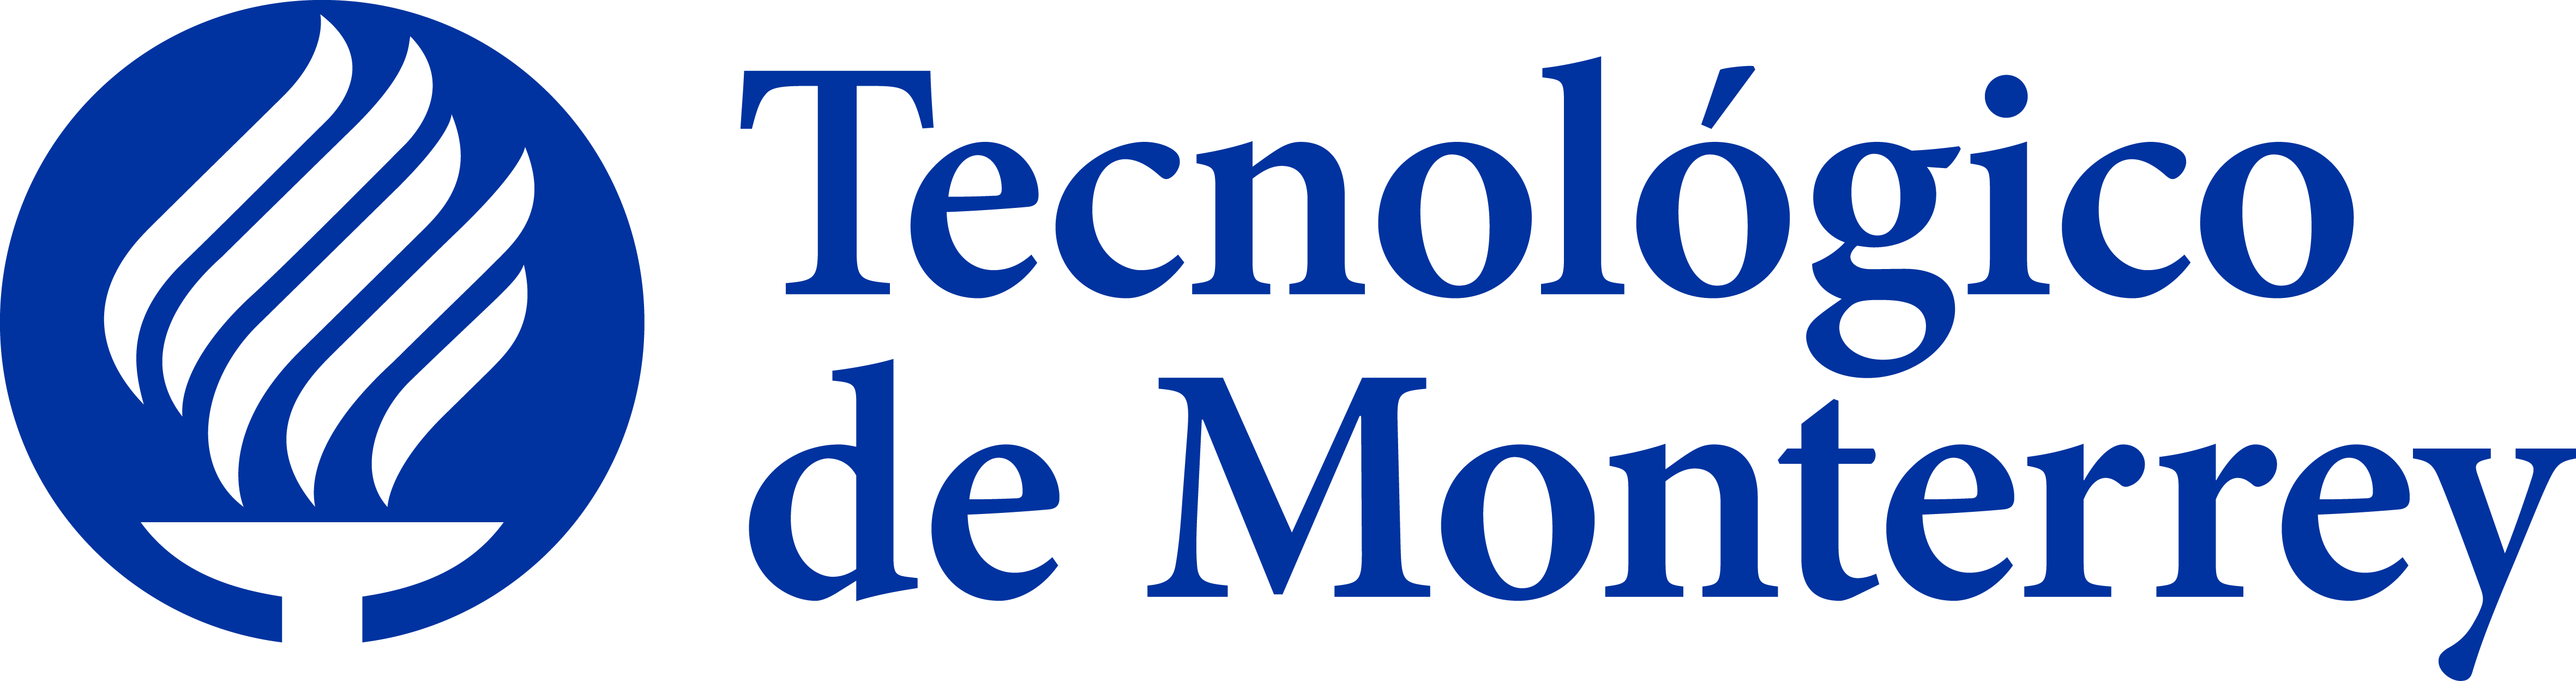

#***Generación de registros sintéticos de velocidad de la onda P***

Cecilia Acevedo Rodríguez
A01793953

# Entregable 1
# Estructura de los datos

##Descripción General de los datos

Los registros geofísicos de pozo (también conocidos como "well logging" en inglés) son mediciones de las propiedades físicas y químicas de las formaciones geológicas a lo largo de un pozo perforado. Estas mediciones se obtienen mediante la introducción de sondas instrumentadas en el pozo, que registran diversos datos en función de la profundidad.

Los datos están almacenados en archivos ".LAS", el formato LAS fue desarrollado por la Canadian Well Logging Society (CWLS). Estos archivos están escritos en código ASCII estándar y por ello se conocen como archivos Log ASCII Standard.

El set de datos está compuesto por 204 archivos de formato LAS que corresponden a 204 pozos de un área determinada.

In [1]:
pip install lasio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 590.3 kB/s eta 0:00:00


In [2]:
import requests
import io
import lasio
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [3]:
def read_las_from_github(repo_url, file_path):
    # Construir la URL del archivo RAW
    raw_file_url = f"{repo_url.rstrip('/').replace('github.com', 'raw.githubusercontent.com')}/main/{file_path}"

    # Obtener el contenido del archivo
    response = requests.get(raw_file_url)
    if response.status_code == 200:
        # Crear un objeto StringIO a partir del contenido del archivo
        file_content = "\n".join(response.text.splitlines())
        file_obj = io.StringIO(file_content)

        # Leer el contenido del archivo LAS
        las_data = lasio.read(file_obj)

        # Convertir los datos LAS a un DataFrame
        las_df = las_data.df()
        return las_df
    else:
        print(f"Error al obtener el archivo LAS desde {raw_file_url}. Código de estado: {response.status_code}")
        return None

def get_files_in_folder(repo_url, folder_path):
    # Construir la URL de la API para obtener el contenido del directorio
    api_url = f"{repo_url.rstrip('/').replace('github.com', 'api.github.com/repos')}/contents/{folder_path}"

    # Realizar la solicitud GET a la API de GitHub
    response = requests.get(api_url)

    if response.status_code == 200:
        # Parsear la respuesta JSON
        data = response.json()

        # Extraer los nombres de los archivos
        file_names = [item['name'] for item in data if item['type'] == 'file']
        return file_names
    else:
        print(f"Error al obtener la lista de archivos del directorio {folder_path}. Código de estado: {response.status_code}")
        return None


def get_data_from_files(repo_url, folder_path):
    file_names = get_files_in_folder(repo_url, folder_path)
    if file_names:
        df = pd.DataFrame()  # DataFrame vacío para almacenar los datos
        for file_name in file_names:
            las_data = read_las_from_github(repo_url, f"{folder_path}/{file_name}")
            if las_data is not None:
                # Combinar datos en el DataFrame
                df = pd.concat([df, las_data], axis=0, ignore_index=True)
        return df
    else:
        return None

# Obtener datos de los archivos y combinar en un DataFrame
repo_url = "https://github.com/cacevedo29/Equipo47"
folder_path = "data"
df = get_data_from_files(repo_url, folder_path)

# Mostrar el DataFrame resultante
print(df)

         CAL  DRHO       DT       GR        ILD  LLD  LLS  MSFL  NPHI  PEF  \
0        NaN   NaN      NaN  21.2810   204.0882  NaN  NaN   NaN   NaN  NaN   
1        NaN   NaN      NaN  20.6261  1103.3665  NaN  NaN   NaN   NaN  NaN   
2        NaN   NaN      NaN  19.9730  2000.0000  NaN  NaN   NaN   NaN  NaN   
3        NaN   NaN      NaN  20.5583  2000.0000  NaN  NaN   NaN   NaN  NaN   
4        NaN   NaN      NaN  21.1400  2000.0000  NaN  NaN   NaN   NaN  NaN   
...      ...   ...      ...      ...        ...  ...  ...   ...   ...  ...   
2936994  NaN   NaN  48.6283      NaN        NaN  NaN  NaN   NaN   NaN  NaN   
2936995  NaN   NaN  48.6318      NaN        NaN  NaN  NaN   NaN   NaN  NaN   
2936996  NaN   NaN  48.6353      NaN        NaN  NaN  NaN   NaN   NaN  NaN   
2936997  NaN   NaN  48.6388      NaN        NaN  NaN  NaN   NaN   NaN  NaN   
2936998  NaN   NaN  48.6423      NaN        NaN  NaN  NaN   NaN   NaN  NaN   

         ...  DTCO  CNL  CNL-ENTUB1  NORM  MINV  RG  DTS  SGFM 

Un pozo se perfora por etapas para asegurar el control de presiones, la estabilidad del pozo, la resolución de problemas operativos, la seguridad, y la adecuada evaluación de las formaciones geológicas, optimizando así el éxito y la eficiencia de la operación de perforación.

Al finalizar cada etapa, se introducen las sondas que miden los registros geofísicos. Sin embargo, no todas las etapas son iguales; es decir, no todas registran las mismas propiedades. Esta variabilidad también se observa entre los distintos pozos, ya que no se recopila la misma información en cada uno de ellos. Esta diferencia justifica la gran cantidad de valores nulos que se encuentran en el data frame.

## Análisis univariante

Este análisis sirve para hacer el control de calidad de la carga de los datos identificando si existe algun valor fuera del rango en cada registro.

In [4]:
# Análisis univariante de cada columna del DataFrame
print(df.describe())


                CAL          DRHO            DT            GR           ILD  \
count  39317.000000  1.000148e+06  1.201853e+06  2.558755e+06  1.475955e+06   
mean       6.316222 -2.847235e+01  8.400004e+01  4.220339e+01  8.036239e+01   
std        6.141392  2.382719e+02  9.143841e+02  6.102206e+02  2.565835e+03   
min     -653.677400 -1.998500e+03 -1.000000e+06 -9.557048e+05 -7.493880e+02   
25%        0.000000  0.000000e+00  5.505900e+01  3.000640e+01  8.620000e-01   
50%        7.941500  1.570000e-02  7.208450e+01  4.071700e+01  1.105100e+00   
75%        9.816100  5.050000e-02  1.141634e+02  5.176060e+01  1.587000e+00   
max       21.999700  2.759517e+03  4.001000e+03  1.130848e+03  1.000000e+06   

                  LLD            LLS           MSFL          NPHI  \
count   881225.000000   858741.00000  740662.000000  1.264565e+06   
mean      1893.291490     1740.50422     245.074596 -1.021404e+02   
std       8223.332224    15386.93949    1616.114409  3.322260e+03   
min   -10000

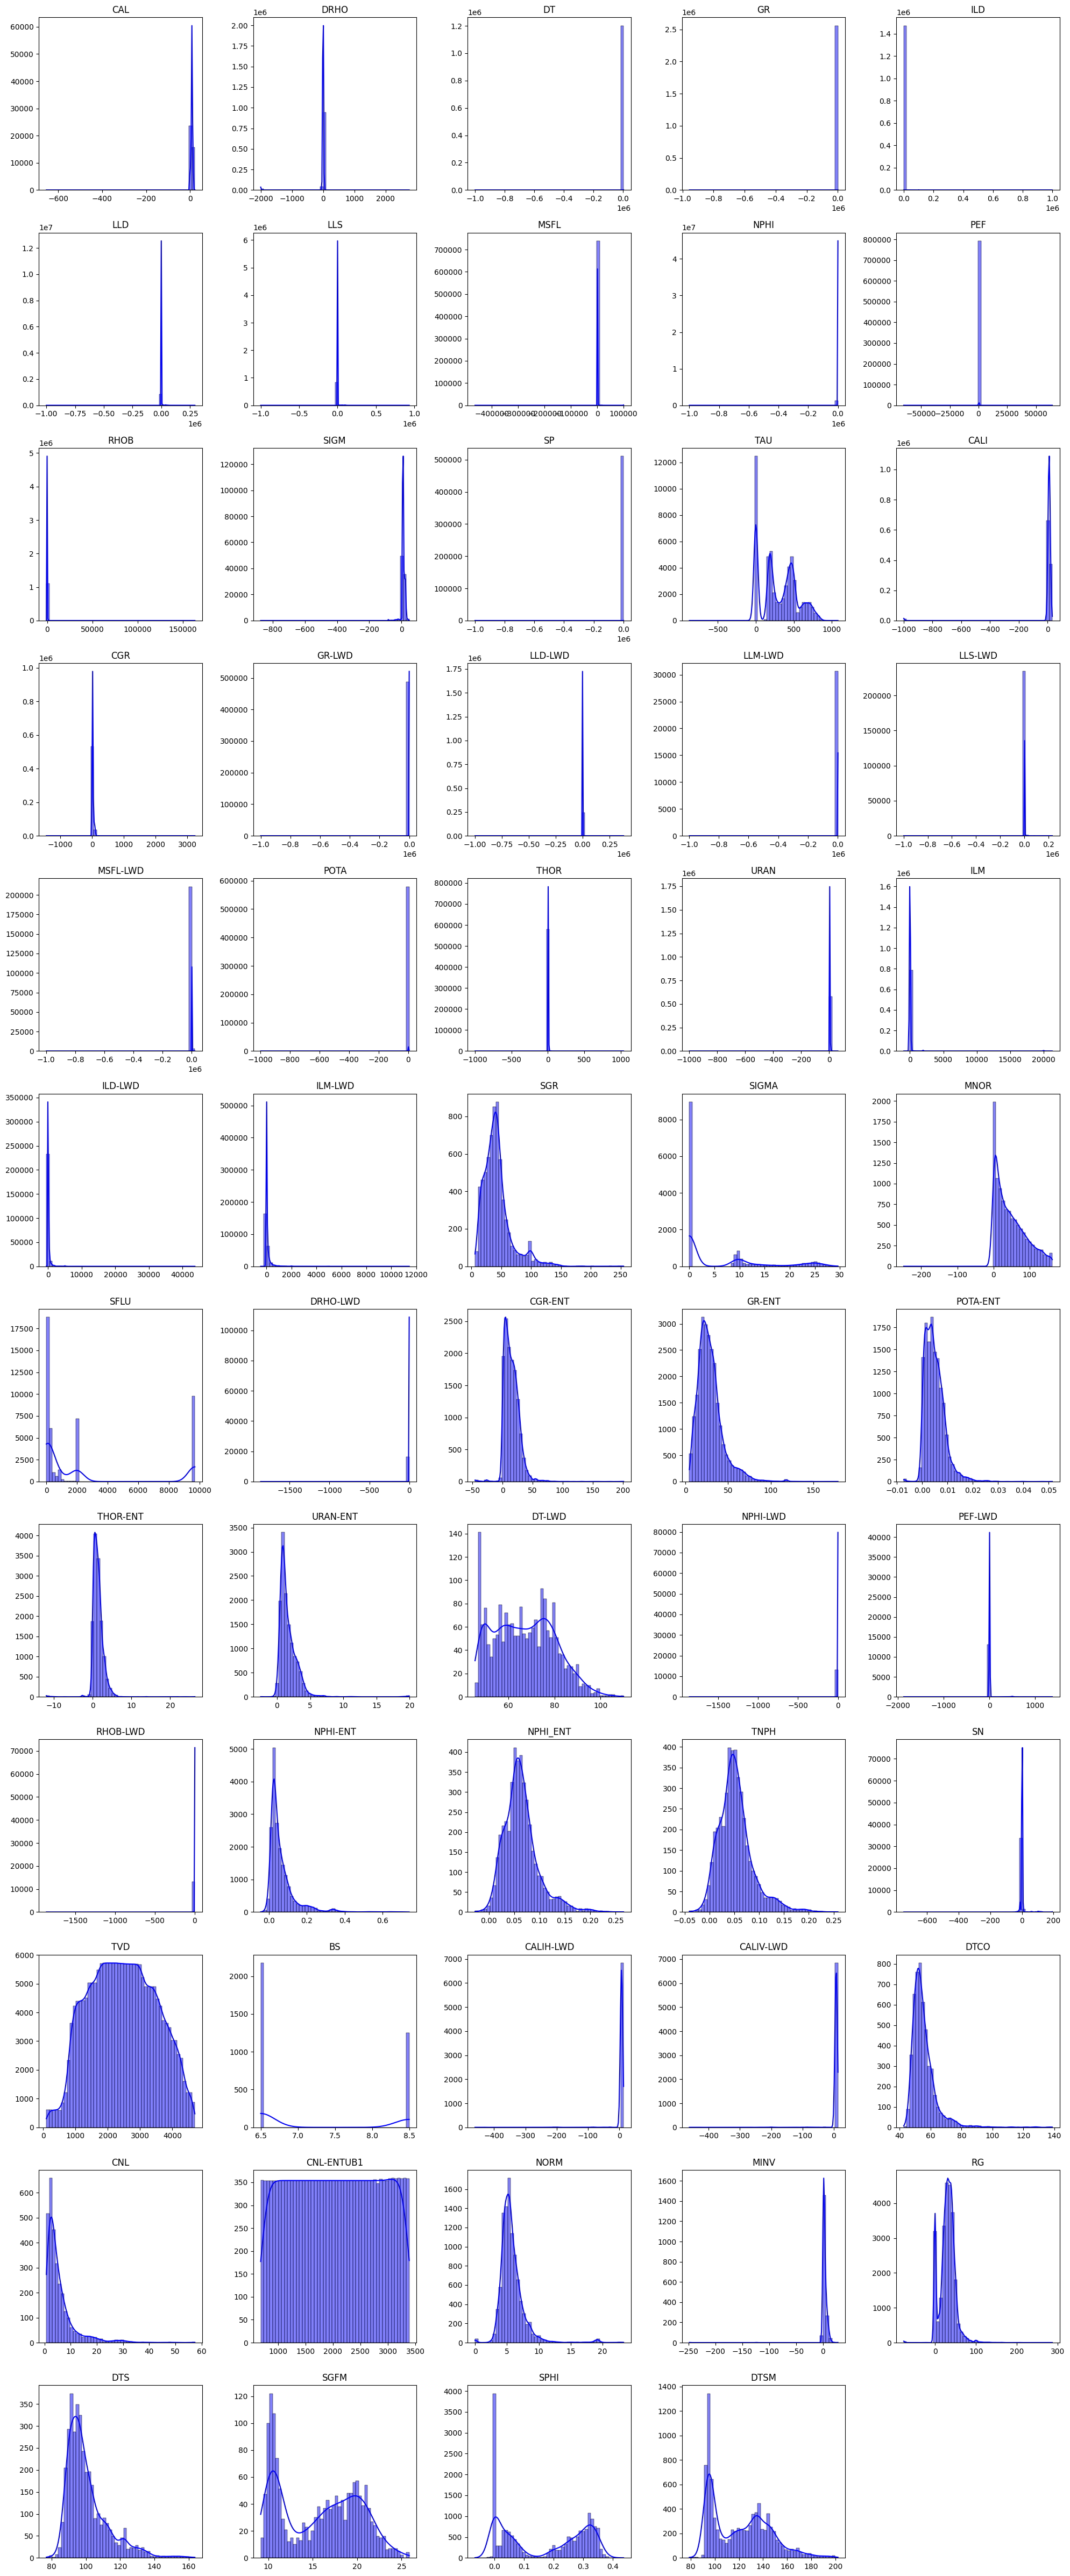

In [5]:
import seaborn as sns

# Configuración de la gráfica
num_cols = 5
num_rows = int(len(df.columns) / num_cols) + 1

plt.figure(figsize=(20, num_rows * 4))

# Crear un histograma para cada columna del DataFrame
for i, column in enumerate(df.columns):
    plt.subplot(num_rows, num_cols, i + 1)
    sns.histplot(df[column].dropna(), bins=50, kde=True, color='blue')
    plt.title(column)
    plt.xlabel('')
    plt.ylabel('')

plt.tight_layout()
plt.show()

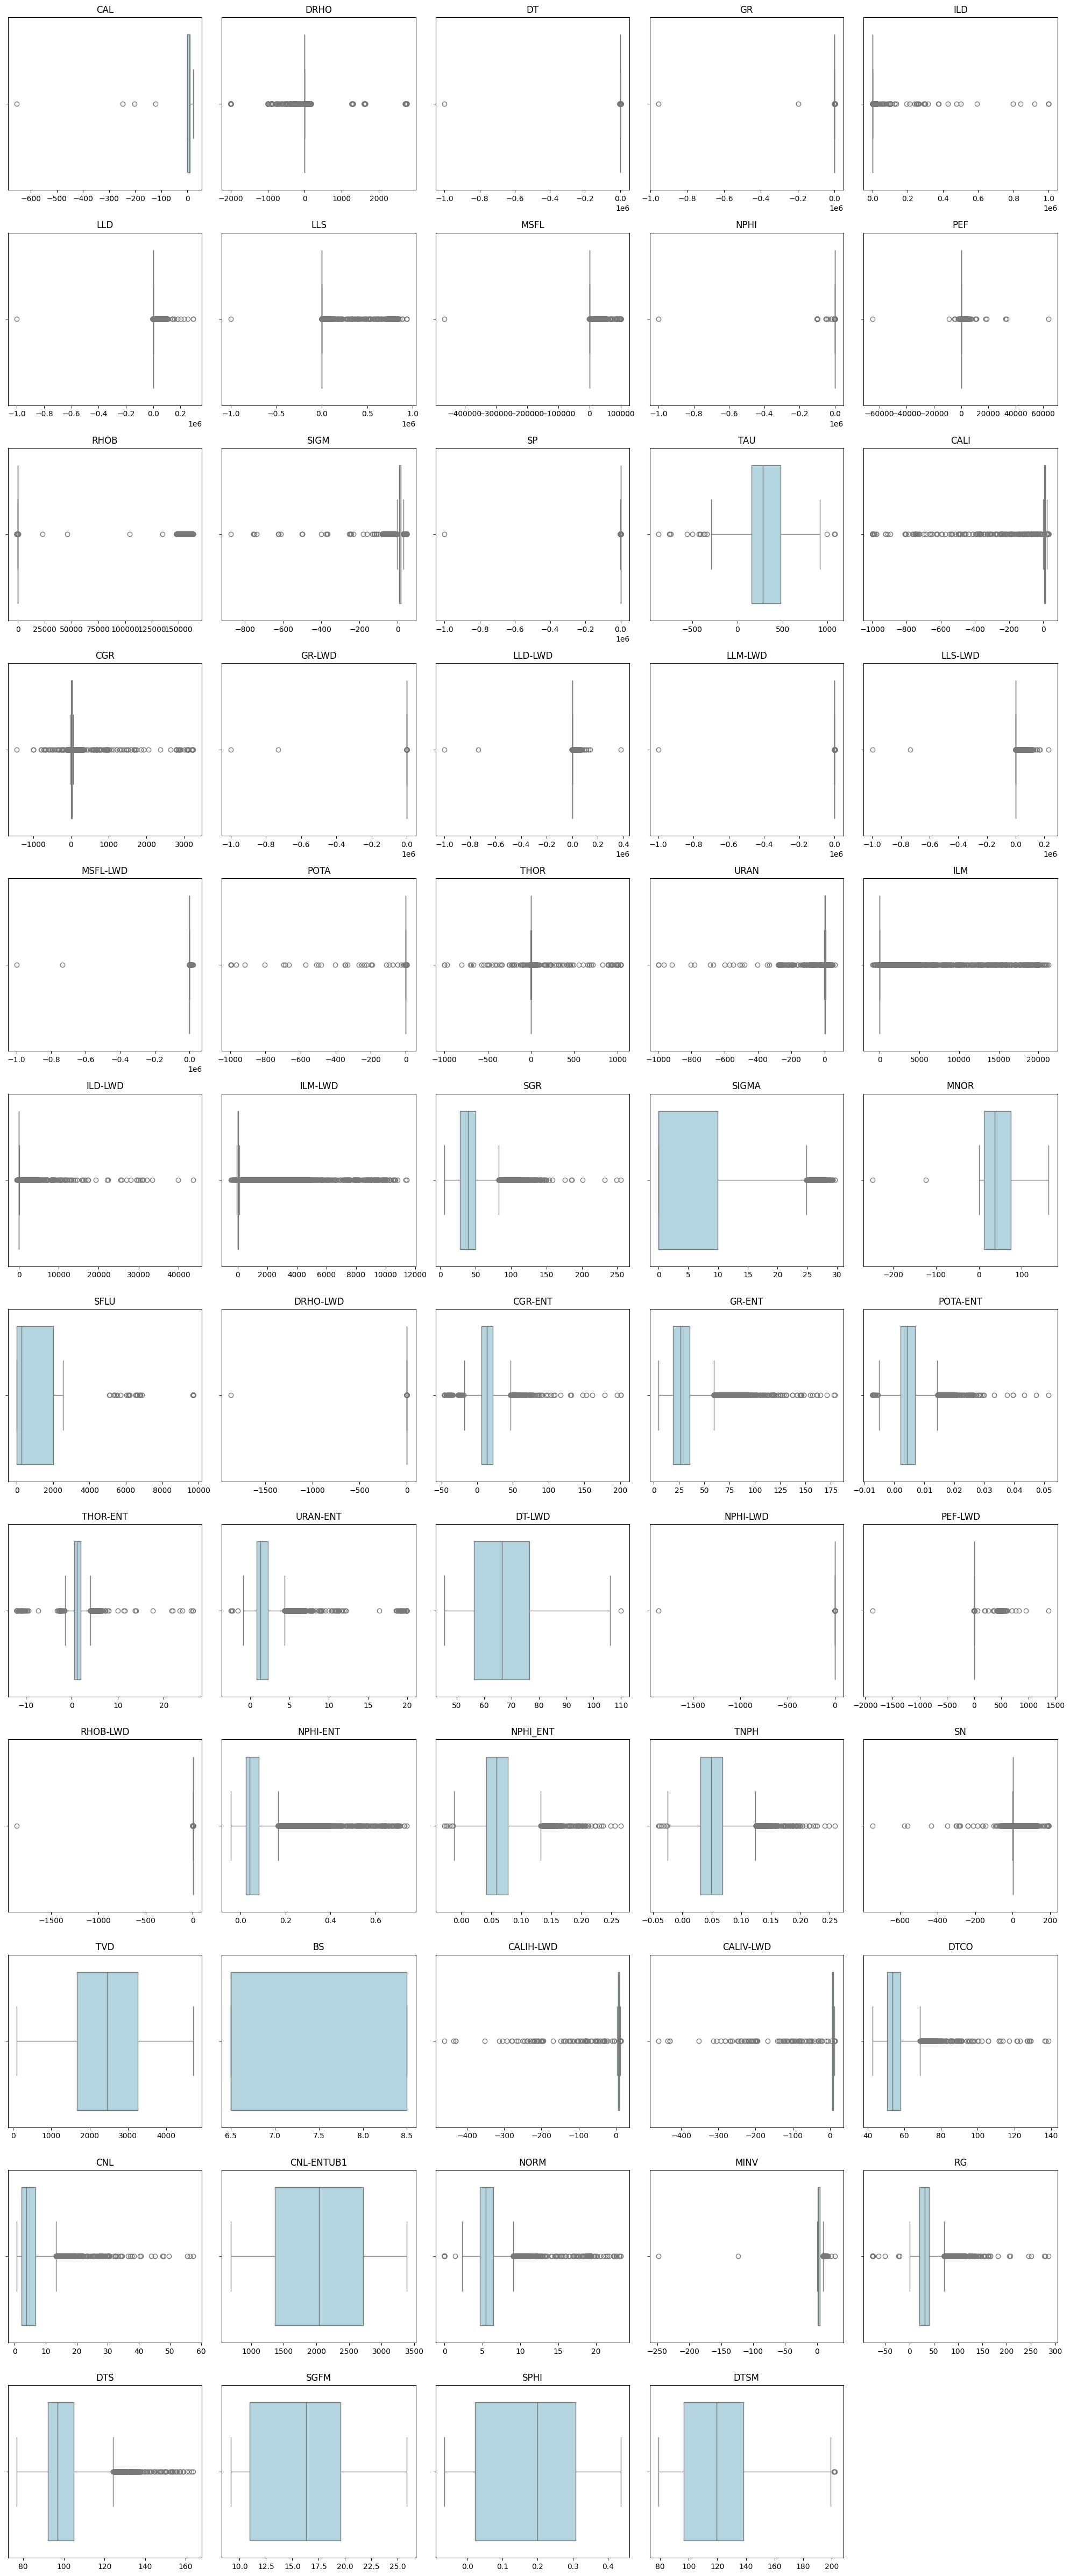

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de la gráfica
num_cols = 5
num_rows = int(len(df.columns) / num_cols) + 1

plt.figure(figsize=(20, num_rows * 4))

# Crear un boxplot para cada columna del DataFrame
for i, column in enumerate(df.columns):
    plt.subplot(num_rows, num_cols, i + 1)
    sns.boxplot(x=df[column], color='lightblue')
    plt.title(column)
    plt.xlabel('')
    plt.ylabel('')

plt.tight_layout()
plt.show()


 ## Análisis multivariante




In [7]:
# Análisis de correlaciones
correlation_matrix = df.corr()
print(correlation_matrix)


                 CAL      DRHO        DT        GR       ILD       LLD  \
CAL         1.000000 -0.654942  0.562849  0.395005 -0.009784  0.074542   
DRHO       -0.654942  1.000000 -0.003569 -0.012021 -0.012558  0.008695   
DT          0.562849 -0.003569  1.000000  0.001062 -0.090222 -0.016497   
GR          0.395005 -0.012021  0.001062  1.000000 -0.025882 -0.098265   
ILD        -0.009784 -0.012558 -0.090222 -0.025882  1.000000  0.005963   
LLD         0.074542  0.008695 -0.016497 -0.098265  0.005963  1.000000   
LLS         0.191058  0.008849  0.007281 -0.028181  0.001740  0.443955   
MSFL       -0.005613  0.012404 -0.010972 -0.036101  0.012876  0.149967   
NPHI        0.459208  0.000341  0.005123  0.009282  0.004827  0.002876   
PEF         0.111926  0.001758  0.000062 -0.013379 -0.007658 -0.003558   
RHOB        0.394187  0.001674  0.000523  0.001959  0.007569 -0.006208   
SIGM       -0.065291  0.008056  0.043959  0.164215  0.055014  0.038620   
SP          0.123121 -0.009090  0.0086

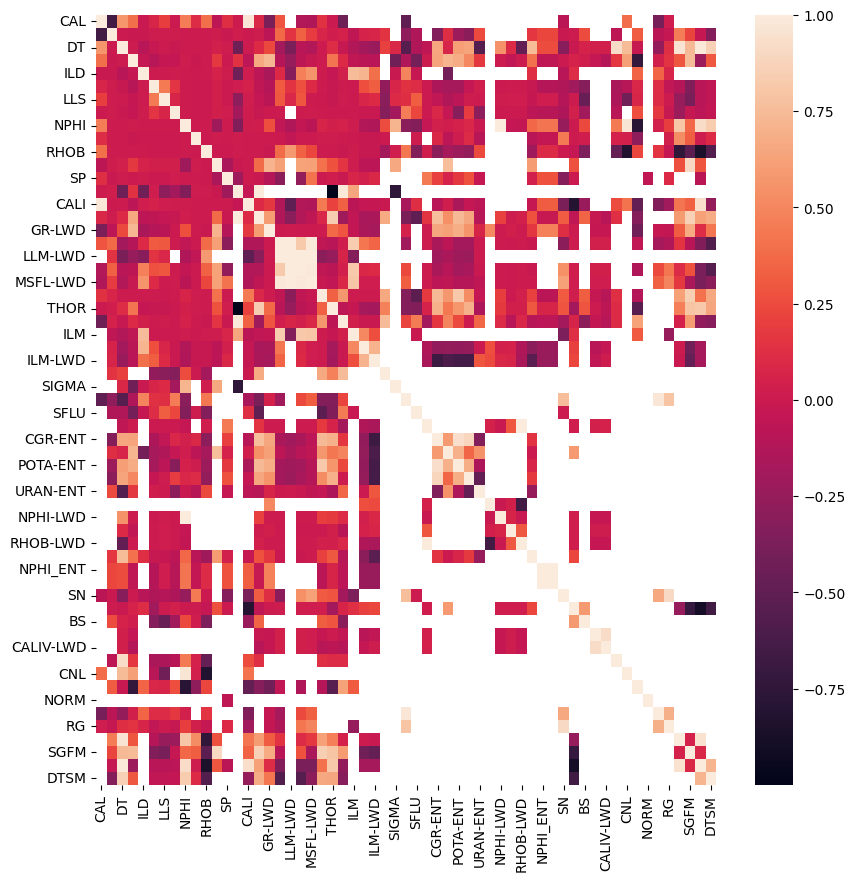

In [8]:
correlation_df = pd.DataFrame(correlation_matrix)

# Create a figure with the desired figsize
plt.figure(figsize=(10, 10))

# Plot the heatmap on the figure
sns.heatmap(correlation_df, annot=False)
plt.show()

## Preprocesamiento

En esta sección limpiaremos el data set, como pudimos ver anteriormente tenemos un gran número de registros dentro de los archivos; sin embargo, para la creación del modelo solo necesitamos los registros cuyos valores están asociados a las propiedades de las rocas los cuales describo a continuación:

**Registros de Resistencia (Resistividad) [RT]**
Propósito: Determinan la capacidad de las formaciones para resistir el flujo de corriente eléctrica.
Aplicaciones: Identificación de hidrocarburos (que son resistivos en comparación con las formaciones acuíferas).

**Registros de Gamma Natural [GR]**
Propósito: Miden la radioactividad natural de las formaciones.
Aplicaciones: Identificación de lutitas y otros minerales radioactivos.

**Registros de Densidad [RHOB]**
Propósito: Miden la densidad de las formaciones.
Aplicaciones: Evaluación de la porosidad y estimación de la saturación de fluidos.

**Registros de Neutrón [NPHI]**
Propósito: Miden la concentración de hidrógeno en las formaciones.
Aplicaciones: Determinación de la porosidad y detección de hidrocarburos.

**Registros Sónicos [DT]**
Propósito: Miden la velocidad de las ondas sonoras a través de las formaciones.
Aplicaciones: Determinación de las propiedades elásticas de las rocas, correlación de formación y detección de fracturas.

In [9]:
# Lista de registros a conservar
registros_a_conservar = ['ILD', 'RG', 'GR', 'SGR', 'TNPH', 'NPHI_ENT', 'NPHI', 'GR-ENT', 'RHOB', 'LLD', 'NPHI-ENT', 'DT', 'DTCO']

# Filtrar el DataFrame para conservar solo los registros especificados
df_filtrado = df[df.columns.intersection(registros_a_conservar)]

# Mostrar el DataFrame filtrado
print(df_filtrado)

new_df = df_filtrado


              DT       GR        ILD  LLD  NPHI  RHOB  SGR  GR-ENT  NPHI-ENT  \
0            NaN  21.2810   204.0882  NaN   NaN   NaN  NaN     NaN       NaN   
1            NaN  20.6261  1103.3665  NaN   NaN   NaN  NaN     NaN       NaN   
2            NaN  19.9730  2000.0000  NaN   NaN   NaN  NaN     NaN       NaN   
3            NaN  20.5583  2000.0000  NaN   NaN   NaN  NaN     NaN       NaN   
4            NaN  21.1400  2000.0000  NaN   NaN   NaN  NaN     NaN       NaN   
...          ...      ...        ...  ...   ...   ...  ...     ...       ...   
2936994  48.6283      NaN        NaN  NaN   NaN   NaN  NaN     NaN       NaN   
2936995  48.6318      NaN        NaN  NaN   NaN   NaN  NaN     NaN       NaN   
2936996  48.6353      NaN        NaN  NaN   NaN   NaN  NaN     NaN       NaN   
2936997  48.6388      NaN        NaN  NaN   NaN   NaN  NaN     NaN       NaN   
2936998  48.6423      NaN        NaN  NaN   NaN   NaN  NaN     NaN       NaN   

         NPHI_ENT  TNPH  DTCO  RG  
0  

In [10]:
new_df

,DT,GR,ILD,LLD,NPHI,RHOB,SGR,GR-ENT,NPHI-ENT,NPHI_ENT,TNPH,DTCO,RG
0,NaN,21.2810,204.0882,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,20.6261,1103.3665,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,19.9730,2000.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,20.5583,2000.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,21.1400,2000.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2936994,48.6283,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2936995,48.6318,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2936996,48.6353,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2936997,48.6388,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Conclusiones entregable 1

Hasta aquí ya tenemos solo las columnas que contienen los registros deseados; sin embargo, podemos observar que tenemos trece columnas cuando solo deberían ser cinco, lo que sucede es que un mismo registro puede llamarse diferente en algún archivo. Adicionalmente aún se observan valores nulos.


#Entregable 2

##Construcción

En esta sección combinaremos las columnas que corresponden a la misma propiedad.

In [11]:
# Definir función para calcular la columna RT
def calcular_RT(fila):
    if not np.isnan(fila['ILD']) and np.isnan(fila['LLD']):
        return fila['ILD']
    elif np.isnan(fila['ILD']) and not np.isnan(fila['LLD']):
        return fila['LLD']
    elif np.isnan(fila['ILD']) and np.isnan(fila['LLD']):
        return np.nan
    else:
        return fila['ILD']

# Aplicar la función calcular_RT para crear la columna RT
new_df['RT'] = new_df.apply(calcular_RT, axis=1)

new_df = new_df.drop(columns=['ILD', 'LLD'])

# Mostrar las primeras filas del DataFrame para verificar que las columnas se han eliminado
new_df

<ipython-input-11-0411b2430946>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['RT'] = new_df.apply(calcular_RT, axis=1)


,DT,GR,NPHI,RHOB,SGR,GR-ENT,NPHI-ENT,NPHI_ENT,TNPH,DTCO,RG,RT
0,NaN,21.2810,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0882
1,NaN,20.6261,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1103.3665
2,NaN,19.9730,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000.0000
3,NaN,20.5583,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000.0000
4,NaN,21.1400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000.0000
...,...,...,...,...,...,...,...,...,...,...,...,...
2936994,48.6283,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2936995,48.6318,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2936996,48.6353,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2936997,48.6388,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
new_df2 = new_df

In [13]:
# Creación de nuevas columnas combinadas
def combinar_valores_GR(row):
    if not np.isnan(row['GR']):
        return row['GR']
    elif not np.isnan(row['RG']):
        return row['RG']
    elif not np.isnan(row['SGR']):
        return row['SGR']
    elif not np.isnan(row['GR-ENT']):
        return row['GR-ENT']
    else:
        return np.nan

new_df2['Comb'] = new_df2.apply(combinar_valores_GR, axis=1)
new_df2 = new_df2.drop(columns=['RG', 'GR', 'SGR', 'GR-ENT'])

# Crear la nueva columna 'Comb_NPHI'
def combinar_valores_NPHI(row):
    if not np.isnan(row['TNPH']):
        return row['TNPH']
    elif not np.isnan(row['NPHI_ENT']):
        return row['NPHI_ENT']
    elif not np.isnan(row['NPHI']):
        return row['NPHI']
    elif not np.isnan(row['NPHI-ENT']):
        return row['NPHI-ENT']
    else:
        return np.nan

new_df2['Comb_NPHI'] = new_df2.apply(combinar_valores_NPHI, axis=1)
new_df2 = new_df2.drop(columns=['TNPH', 'NPHI_ENT', 'NPHI', 'NPHI-ENT'])

# Crear la nueva columna 'COMB_DT'
def combinar_valores_DT(row):
    if not np.isnan(row['DT']):
        return row['DT']
    elif not np.isnan(row['DTCO']):
        return row['DTCO']
    else:
        return np.nan

new_df2['COMB_DT'] = new_df2.apply(combinar_valores_DT, axis=1)


In [14]:
new_df2

,DT,RHOB,DTCO,RT,Comb,Comb_NPHI,COMB_DT
0,NaN,NaN,NaN,204.0882,21.2810,NaN,NaN
1,NaN,NaN,NaN,1103.3665,20.6261,NaN,NaN
2,NaN,NaN,NaN,2000.0000,19.9730,NaN,NaN
3,NaN,NaN,NaN,2000.0000,20.5583,NaN,NaN
4,NaN,NaN,NaN,2000.0000,21.1400,NaN,NaN
...,...,...,...,...,...,...,...
2936994,48.6283,NaN,NaN,NaN,NaN,NaN,48.6283
2936995,48.6318,NaN,NaN,NaN,NaN,NaN,48.6318
2936996,48.6353,NaN,NaN,NaN,NaN,NaN,48.6353
2936997,48.6388,NaN,NaN,NaN,NaN,NaN,48.6388


In [15]:
# Eliminar las columnas 'DT', 'DTCO'
new_df2 = new_df2.drop(columns=['DT', 'DTCO'])

# Mostrar las primeras filas del DataFrame para verificar que las columnas se han eliminado
new_df2

,RHOB,RT,Comb,Comb_NPHI,COMB_DT
0,NaN,204.0882,21.2810,NaN,NaN
1,NaN,1103.3665,20.6261,NaN,NaN
2,NaN,2000.0000,19.9730,NaN,NaN
3,NaN,2000.0000,20.5583,NaN,NaN
4,NaN,2000.0000,21.1400,NaN,NaN
...,...,...,...,...,...
2936994,NaN,NaN,NaN,NaN,48.6283
2936995,NaN,NaN,NaN,NaN,48.6318
2936996,NaN,NaN,NaN,NaN,48.6353
2936997,NaN,NaN,NaN,NaN,48.6388


In [16]:
# Selección y extracción de características importantes
# Renombrar las columnas 'A' a 'X' y 'B' a 'Y'
df = new_df2.rename(columns={'Comb': 'GR', 'Comb_NPHI': 'NPHI', 'COMB_DT': 'DT' })

# Mostrar las primeras filas del DataFrame para verificar el cambio
df

,RHOB,RT,GR,NPHI,DT
0,NaN,204.0882,21.2810,NaN,NaN
1,NaN,1103.3665,20.6261,NaN,NaN
2,NaN,2000.0000,19.9730,NaN,NaN
3,NaN,2000.0000,20.5583,NaN,NaN
4,NaN,2000.0000,21.1400,NaN,NaN
...,...,...,...,...,...
2936994,NaN,NaN,NaN,NaN,48.6283
2936995,NaN,NaN,NaN,NaN,48.6318
2936996,NaN,NaN,NaN,NaN,48.6353
2936997,NaN,NaN,NaN,NaN,48.6388


Hasta este punto ya tenemos solo las cinco columnas de las propiedades requeridas, ya solo queda quitar los valores nulos.

In [17]:
# Eliminar filas con al menos un valor NaN
df_clean = df.dropna(how='any')

print("\nDataFrame después de eliminar filas con al menos un valor NaN:")
df_clean


DataFrame después de eliminar filas con al menos un valor NaN:


,RHOB,RT,GR,NPHI,DT
12818,2.3150,0.4700,22.0720,0.2615,-219.3950
12819,2.2855,0.8544,24.0396,0.2993,-83.1787
12820,2.2560,1.2380,25.9970,0.3371,51.6810
12821,2.2670,5.2352,24.9453,0.3485,53.6462
12822,2.2780,9.2250,23.8990,0.3599,55.5920
...,...,...,...,...,...
2936919,2.5465,1503.6654,29.8856,0.0930,46.5962
2936920,2.5188,1503.3405,27.8816,0.0931,46.5724
2936921,2.5081,1503.0963,27.4429,0.0933,46.3989
2936922,2.5175,1502.9001,28.0458,0.0934,46.2970


In [18]:
df_clean.describe()

,RHOB,RT,GR,NPHI,DT
count,759381.000000,759381.000000,759381.000000,759381.000000,759381.000000
mean,112.328611,1639.417492,43.245260,1.328593,73.531947
std,4137.888968,7775.517033,26.435016,61.392231,71.020865
min,-897.603000,-1000000.000000,-2240.000000,-49206.472700,-1598.500000
25%,2.409500,1.941300,26.550500,0.056000,52.223500
50%,2.623300,60.137000,38.279000,0.114000,60.300000
75%,2.727000,389.530000,52.447700,0.307900,81.518000
max,163339.921900,476261.437500,743.470100,74.007600,4001.000000


## Normalización

En esta parte no es necesario normalizar los datos aún, ya que la normalizacion se hará una vez que el set de datos este completamente construido.

## Selección-Extracción

En esta sección se filtrarán los datos, ya que como se observa en la descripción anterior hay valores que se salen del rango de las mediciones que deben tener las rocas. Se realizará el filtrado usando valores de corte para cada uno de los registros.

In [19]:
# Definir las condiciones de filtrado para cada columna
condition_RT = (df_clean['RT'] >= 0.2) & (df_clean['RT'] <= 10000)
condition_GR = (df_clean['GR'] >= 0) & (df_clean['GR'] <= 150)
condition_NPHI = (df_clean['NPHI'] >= -0.15) & (df_clean['NPHI'] <= 0.45)
condition_DT = (df_clean['DT'] >= 40) & (df_clean['DT'] <= 140)
condition_RHOB = (df_clean['RHOB'] >= 1.5) & (df_clean['RHOB'] <= 3)

# Aplicar todas las condiciones de filtrado simultáneamente
geo_regist = df_clean[condition_RT & condition_GR & condition_NPHI & condition_DT & condition_RHOB]

print("\nDataFrame después de filtrar:")
geo_regist


DataFrame después de filtrar:


,RHOB,RT,GR,NPHI,DT
12820,2.2560,1.2380,25.9970,0.3371,51.6810
12821,2.2670,5.2352,24.9453,0.3485,53.6462
12822,2.2780,9.2250,23.8990,0.3599,55.5920
12823,2.2875,8.2637,24.3379,0.3475,55.6528
12824,2.2970,7.3040,24.7740,0.3352,55.7130
...,...,...,...,...,...
2936919,2.5465,1503.6654,29.8856,0.0930,46.5962
2936920,2.5188,1503.3405,27.8816,0.0931,46.5724
2936921,2.5081,1503.0963,27.4429,0.0933,46.3989
2936922,2.5175,1502.9001,28.0458,0.0934,46.2970


In [20]:
geo_regist

,RHOB,RT,GR,NPHI,DT
12820,2.2560,1.2380,25.9970,0.3371,51.6810
12821,2.2670,5.2352,24.9453,0.3485,53.6462
12822,2.2780,9.2250,23.8990,0.3599,55.5920
12823,2.2875,8.2637,24.3379,0.3475,55.6528
12824,2.2970,7.3040,24.7740,0.3352,55.7130
...,...,...,...,...,...
2936919,2.5465,1503.6654,29.8856,0.0930,46.5962
2936920,2.5188,1503.3405,27.8816,0.0931,46.5724
2936921,2.5081,1503.0963,27.4429,0.0933,46.3989
2936922,2.5175,1502.9001,28.0458,0.0934,46.2970


In [21]:
# Guardar el DataFrame como un archivo CSV en el entorno de ejecución local
geo_regist.to_csv('geo_regist.csv', index=False)


# Conclusiones Entregable 2

Se logró obtener un buen set de datos después de todos los procesos de limpieza y filtrado aplicados, el número de registros es adecuado para la generación de un modelo.